The goal of this notebook is to predict the weather of the city of San Francisco using advanced RNN such as LSTM and GRU. In the first step, we would predict the temperature, knowing the information of the past days.

First load the dataset from `San_Francisco.csv`.

In [ ]:
!ls

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LayerNormalization
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, LSTM, GRU, Dropout, Bidirectional

In [3]:
# Load the dataset
df = pd.read_csv("./San_Francisco.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        45253 non-null  object 
 1   Humidity        44311 non-null  float64
 2   Pressure        44438 non-null  float64
 3   Temperature     44460 non-null  float64
 4   Description     44460 non-null  object 
 5   Wind direction  44459 non-null  float64
 6   Wind speed      44459 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.4+ MB


In [4]:
df.head()

,datetime,Humidity,Pressure,Temperature,Description,Wind direction,Wind speed
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,88.0,1009.0,289.480000,light rain,150.0,2.0
2,2012-10-01 14:00:00,87.0,1009.0,289.474993,sky is clear,147.0,2.0
3,2012-10-01 15:00:00,86.0,1009.0,289.460618,sky is clear,141.0,2.0
4,2012-10-01 16:00:00,85.0,1009.0,289.446243,sky is clear,135.0,2.0


In [5]:
df['months'] = pd.to_datetime(df['datetime']).dt.month
df['years'] = pd.to_datetime(df['datetime']).dt.year
df['days'] = pd.to_datetime(df['datetime']).dt.day
df['time'] = pd.to_datetime(df['datetime']).dt.time
df['hours'] = pd.to_datetime(df['datetime']).dt.hour
df.sample(30)

,datetime,Humidity,Pressure,Temperature,Description,Wind direction,Wind speed,months,years,days,time,hours
31928,2016-05-23 20:00:00,55.0,1015.0,293.310000,scattered clouds,280.0,8.0,5,2016,23,20:00:00,20
27539,2015-11-22 23:00:00,63.0,1014.0,292.070000,haze,140.0,2.0,11,2015,22,23:00:00,23
34182,2016-08-25 18:00:00,77.0,1015.0,290.630000,mist,310.0,4.0,8,2016,25,18:00:00,18
5307,2013-05-10 15:00:00,87.0,1022.0,285.110000,overcast clouds,340.0,3.0,5,2013,10,15:00:00,15
2309,2013-01-05 17:00:00,65.0,1026.0,279.130000,mist,110.0,2.0,1,2013,5,17:00:00,17
5214,2013-05-06 18:00:00,51.0,1006.0,289.850000,overcast clouds,170.0,10.0,5,2013,6,18:00:00,18
4201,2013-03-25 13:00:00,76.0,1003.0,280.250000,mist,240.0,2.0,3,2013,25,13:00:00,13
25221,2015-08-18 09:00:00,87.0,1013.0,289.310000,smoke,300.0,2.0,8,2015,18,09:00:00,9
42105,2017-07-21 21:00:00,32.0,1015.0,297.810000,sky is clear,190.0,5.0,7,2017,21,21:00:00,21
5312,2013-05-10 20:00:00,62.0,1022.0,290.730000,scattered clouds,280.0,6.0,5,2013,10,20:00:00,20


In [6]:
df = df[['datetime', 'years', 'months', 'days', 'hours', 'Humidity', 'Pressure', 'Temperature', 'Wind direction', 'Wind speed', 'Description']]
df.sample(10)

,datetime,years,months,days,hours,Humidity,Pressure,Temperature,Wind direction,Wind speed,Description
8845,2013-10-05 01:00:00,2013,10,5,1,18.0,1017.0,297.680000,105.0,0.0,sky is clear
34067,2016-08-20 23:00:00,2016,8,20,23,64.0,1013.0,298.680000,290.0,7.0,thunderstorm
29704,2016-02-21 04:00:00,2016,2,21,4,81.0,1020.0,284.360603,314.0,2.0,scattered clouds
33360,2016-07-22 12:00:00,2016,7,22,12,87.0,1019.0,285.660000,200.0,3.0,broken clouds
19138,2014-12-07 22:00:00,2014,12,7,22,97.0,1033.0,288.088333,110.0,2.0,broken clouds
12363,2014-02-28 15:00:00,2014,2,28,15,93.0,995.0,285.580000,120.0,4.0,overcast clouds
20303,2015-01-25 11:00:00,2015,1,25,11,98.0,1034.0,282.059667,64.0,2.0,sky is clear
19912,2015-01-09 04:00:00,2015,1,9,4,91.0,1030.0,284.877333,36.0,1.0,broken clouds
18202,2014-10-29 22:00:00,2014,10,29,22,61.0,1029.0,294.295333,37.0,1.0,sky is clear
15318,2014-07-01 18:00:00,2014,7,1,18,66.0,1008.0,293.248823,215.0,2.0,sky is clear


In [7]:
num_columns = df.select_dtypes(include=['number']).columns
num_columns

Index(['years', 'months', 'days', 'hours', 'Humidity', 'Pressure',
       'Temperature', 'Wind direction', 'Wind speed'],
      dtype='object')

In [8]:
df.iloc[44978]

datetime          2017-11-18 14:00:00
years                            2017
months                             11
days                               18
hours                              14
Humidity                          NaN
Pressure                          NaN
Temperature                       NaN
Wind direction                    NaN
Wind speed                        NaN
Description                       NaN
Name: 44978, dtype: object

Explore the dataset, make the data preparation.

In [9]:
df_clean = df.copy()
df_clean.Description.unique()

array([nan, 'light rain', 'sky is clear', 'haze', 'scattered clouds',
       'overcast clouds', 'broken clouds', 'mist', 'few clouds', 'fog',
       'proximity thunderstorm', 'light intensity drizzle',
       'moderate rain', 'thunderstorm', 'heavy intensity rain',
       'thunderstorm with heavy rain', 'proximity shower rain',
       'heavy intensity drizzle', 'heavy snow', 'drizzle',
       'thunderstorm with rain', 'thunderstorm with light rain',
       'very heavy rain', 'proximity thunderstorm with rain',
       'light intensity shower rain', 'smoke', 'shower rain', 'squalls',
       'light snow'], dtype=object)

In [10]:
for ncol in num_columns:
    df_clean[ncol] = df_clean[ncol].apply(lambda x: 0.0 if pd.isna(x) else x)

df_clean.iloc[44978]

datetime          2017-11-18 14:00:00
years                            2017
months                             11
days                               18
hours                              14
Humidity                          0.0
Pressure                          0.0
Temperature                       0.0
Wind direction                    0.0
Wind speed                        0.0
Description                       NaN
Name: 44978, dtype: object

<AxesSubplot:xlabel='count', ylabel='Description'>

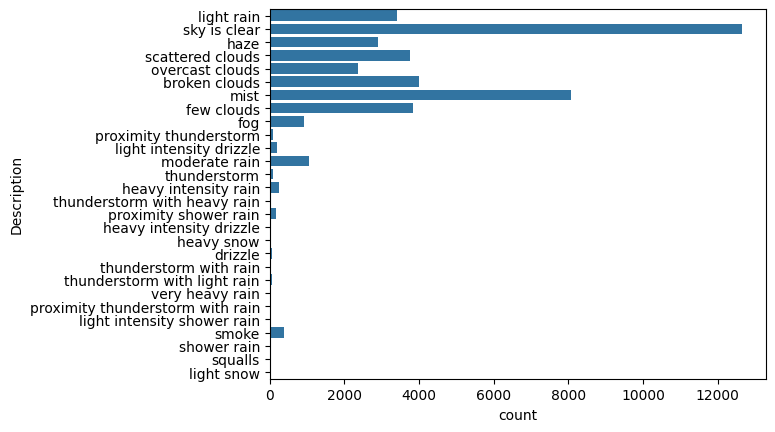

In [11]:
sns.countplot(df_clean['Description'])

In [12]:
df_clean = df_clean.dropna()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44460 entries, 1 to 44460
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        44460 non-null  object 
 1   years           44460 non-null  int64  
 2   months          44460 non-null  int64  
 3   days            44460 non-null  int64  
 4   hours           44460 non-null  int64  
 5   Humidity        44460 non-null  float64
 6   Pressure        44460 non-null  float64
 7   Temperature     44460 non-null  float64
 8   Wind direction  44460 non-null  float64
 9   Wind speed      44460 non-null  float64
 10  Description     44460 non-null  object 
dtypes: float64(5), int64(4), object(2)
memory usage: 4.1+ MB


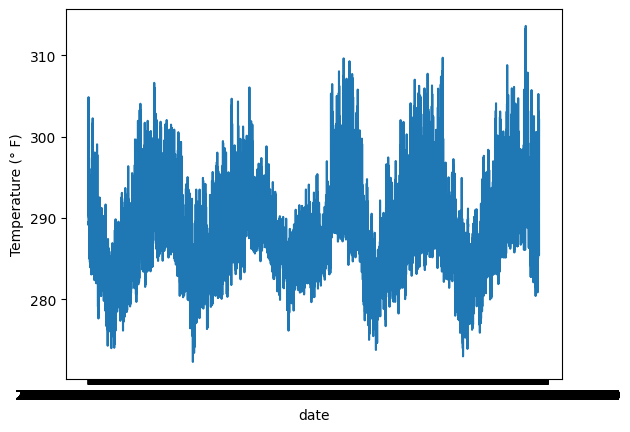

In [13]:
register_matplotlib_converters()

plt.plot(df['datetime'], df['Temperature'])
plt.xlabel('date')
plt.ylabel('Temperature (° F)')
plt.show()

In [14]:
df_clean = df_clean.drop(columns='datetime')
df_clean.sample(10)

,years,months,days,hours,Humidity,Pressure,Temperature,Wind direction,Wind speed,Description
14905,2014,6,14,13,95.0,1026.0,284.779333,227.0,1.0,sky is clear
17958,2014,10,19,18,85.0,1025.0,289.479500,230.0,1.0,sky is clear
14544,2014,5,30,12,76.0,1013.0,283.230000,230.0,2.0,sky is clear
31538,2016,5,7,14,87.0,1014.0,286.080000,220.0,1.0,mist
33112,2016,7,12,4,77.0,1013.0,291.650000,270.0,9.0,mist
11747,2014,2,2,23,81.0,1011.0,281.900000,110.0,6.0,moderate rain
30781,2016,4,6,1,63.0,1012.0,298.440115,134.0,7.0,few clouds
27746,2015,12,1,14,88.0,1015.0,277.840000,170.0,2.0,moderate rain
38742,2017,3,3,18,76.0,1020.0,284.980000,311.0,0.0,mist
43571,2017,9,20,23,68.0,1012.0,294.630000,270.0,8.0,broken clouds


In [15]:
tokenizer = Tokenizer()

In [16]:
tokenizer.get_config()

{'num_words': None,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': None,
 'document_count': 0,
 'word_counts': '{}',
 'word_docs': '{}',
 'index_docs': '{}',
 'index_word': '{}',
 'word_index': '{}'}

In [17]:
tokenizer.fit_on_texts(df_clean['Description'])
sequences = tokenizer.texts_to_sequences(df_clean['Description'])
print("First 10 sequences", sequences[:10], "Going till", len(sequences))

First 10 sequences [[10, 6], [2, 3, 4], [2, 3, 4], [2, 3, 4], [2, 3, 4], [2, 3, 4], [2, 3, 4], [2, 3, 4], [2, 3, 4], [2, 3, 4]] Going till 44460


In [18]:
df_clean['Description_tokenized'] = sequences
df_clean.sample(10)

,years,months,days,hours,Humidity,Pressure,Temperature,Wind direction,Wind speed,Description,Description_tokenized
42479,2017,8,6,11,100.0,1013.0,289.490000,230.0,1.0,mist,[5]
12713,2014,3,15,5,67.0,1023.0,286.410000,290.0,6.0,sky is clear,"[2, 3, 4]"
31870,2016,5,21,10,71.0,1014.0,284.090000,250.0,4.0,mist,[5]
41006,2017,6,6,2,83.0,1008.0,297.760000,10.0,2.0,light rain,"[10, 6]"
26092,2015,9,23,16,72.0,1017.0,288.590000,360.0,1.0,mist,[5]
27158,2015,11,7,2,86.0,1027.0,288.916241,281.0,2.0,scattered clouds,"[9, 1]"
2989,2013,2,3,1,72.0,1021.0,288.230000,300.0,3.0,haze,[11]
16890,2014,9,5,6,92.0,1021.0,289.621500,228.0,1.0,scattered clouds,"[9, 1]"
409,2012,10,18,13,93.0,1012.0,286.110000,0.0,0.0,mist,[5]
2693,2013,1,21,17,75.0,1024.0,280.650000,0.0,0.0,scattered clouds,"[9, 1]"


PS : These suquences must be padded to ensure uniform input length.

In [19]:
# Compute X and y
X = df_clean.drop(columns=['Temperature', 'Description', 'Description_tokenized'])
y = df_clean['Temperature']

In [20]:
type(X.Humidity.values[0])

numpy.float64

In [21]:
X[['years', 'months', 'days', 'hours']] = np.float64(X[['years', 'months', 'days', 'hours']])

In [22]:
X_array =  np.asarray(X)
X_array

array([[2.012e+03, 1.000e+01, 1.000e+00, ..., 1.009e+03, 1.500e+02,
        2.000e+00],
       [2.012e+03, 1.000e+01, 1.000e+00, ..., 1.009e+03, 1.470e+02,
        2.000e+00],
       [2.012e+03, 1.000e+01, 1.000e+00, ..., 1.009e+03, 1.410e+02,
        2.000e+00],
       ...,
       [2.017e+03, 1.000e+01, 2.700e+01, ..., 1.014e+03, 0.000e+00,
        2.000e+00],
       [2.017e+03, 1.000e+01, 2.700e+01, ..., 1.013e+03, 1.200e+02,
        2.000e+00],
       [2.017e+03, 1.000e+01, 2.800e+01, ..., 1.013e+03, 1.300e+02,
        2.000e+00]])

In [23]:
normalization = LayerNormalization(axis=1)
X_norm = normalization(X_array)

2024-09-02 19:53:54.262479: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-02 19:53:54.262665: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-02 19:53:54.262689: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-02 19:53:54.262980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-02 19:53:54.263490: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
X_norm[0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 2.3396316 , -0.5853188 , -0.59846795, -0.5809358 , -0.47135973,
        0.87423444, -0.38077682, -0.5970069 ], dtype=float32)>

PS : better use layerNormalization in the Neural Network (as it was designed for). One of it's major benefits is batch nomalization. Often used to stabilize and accelerate the training of deep neural networks.

In [25]:
scaler = MinMaxScaler()

In [26]:
X_scaled = scaler.fit_transform(X_array)
X_scaled[0]

array([0.        , 0.81818182, 0.        , 0.56521739, 0.88      ,
       0.9664751 , 0.41666667, 0.04651163])

In [27]:
y.values.reshape(-1, 1)

array([[289.48      ],
       [289.47499281],
       [289.46061811],
       ...,
       [300.56      ],
       [301.06      ],
       [302.07      ]])

In [28]:
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
y_scaled

array([0.41577928, 0.4156581 , 0.41531022, ..., 0.6839303 , 0.69603098,
       0.72047435])

Now build a RNN model that will allow to predict the temperature, knowing the information of the past half day (or more if you chose more!).

Then compile it, fit it on a train dataset.

In [29]:
# Simple function to get features data points at a timestamp till timestamp + past variable (here lookup). For every sequence we will lookup n datapoint (here we will take 24)
def processData(data, past):
    X = []
    for i in range(len(data) - past - 1):
        X.append(data.iloc[i:i+past].values)
    return np.array(X)

In [30]:
data = df[['Humidity', 'Pressure', 'Temperature', 'Wind direction', 'Wind speed']]
data = data.dropna()
data = pd.DataFrame(scaler.fit_transform(data), columns=['Humidity', 'Pressure', 'Temperature', 'Wind direction', 'Wind speed'])
data

,Humidity,Pressure,Temperature,Wind direction,Wind speed
0,0.872340,0.406780,0.415779,0.416667,0.046512
1,0.861702,0.406780,0.415658,0.408333,0.046512
2,0.851064,0.406780,0.415310,0.391667,0.046512
3,0.840426,0.406780,0.414962,0.375000,0.046512
4,0.829787,0.406780,0.414614,0.358333,0.046512
...,...,...,...,...,...
44299,0.234043,0.508475,0.599226,0.769444,0.000000
44300,0.202128,0.491525,0.649564,0.000000,0.046512
44301,0.170213,0.491525,0.683930,0.000000,0.046512
44302,0.148936,0.474576,0.696031,0.333333,0.046512


In [31]:
dfcopy = df.copy()

In [32]:
dfcopy = dfcopy.dropna()
dfcopy

,datetime,years,months,days,hours,Humidity,Pressure,Temperature,Wind direction,Wind speed,Description
1,2012-10-01 13:00:00,2012,10,1,13,88.0,1009.0,289.480000,150.0,2.0,light rain
2,2012-10-01 14:00:00,2012,10,1,14,87.0,1009.0,289.474993,147.0,2.0,sky is clear
3,2012-10-01 15:00:00,2012,10,1,15,86.0,1009.0,289.460618,141.0,2.0,sky is clear
4,2012-10-01 16:00:00,2012,10,1,16,85.0,1009.0,289.446243,135.0,2.0,sky is clear
5,2012-10-01 17:00:00,2012,10,1,17,84.0,1009.0,289.431869,129.0,2.0,sky is clear
...,...,...,...,...,...,...,...,...,...,...,...
44456,2017-10-27 20:00:00,2017,10,27,20,28.0,1015.0,297.060000,277.0,0.0,sky is clear
44457,2017-10-27 21:00:00,2017,10,27,21,25.0,1014.0,299.140000,0.0,2.0,sky is clear
44458,2017-10-27 22:00:00,2017,10,27,22,22.0,1014.0,300.560000,0.0,2.0,sky is clear
44459,2017-10-27 23:00:00,2017,10,27,23,20.0,1013.0,301.060000,120.0,2.0,sky is clear


In [33]:
lookback = 24 # data for one day day
y = dfcopy['Temperature'][lookback+1:]
X_prep = processData(data, lookback)
X_prep.shape, y.shape

((44279, 24, 5), (44279,))

In [34]:
X_prep.shape[1:]

(24, 5)

In [35]:
def my_GRU(input_shape):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units=32, return_sequences=True, activation='relu'))
    model.add(GRU(units=32, activation='relu', return_sequences=False))
    model.add(Dense(units=1, activation='linear'))

    return model

model = my_GRU(X_prep.shape[1:])

model.compile(optimizer='adam',
              loss='mean_squared_error')

X_train = X_prep[:40000]
y_train = y.values[:40000]
X_test = X_prep[40000:]
y_test = y.values[40000:]

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 32)         │         3,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,113 (39.50 KB)

 Trainable params: 10,113 (39.50 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 24, 5), (4279, 24, 5), (40000,), (4279,))

For complex architectures like GRU, be prepared for significant training time (run on GPU, took me about 45min for 2.6 TFLOPS).

In [ ]:
tf.config.run_functions_eagerly(True)
model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=15, batch_size=64)

In [41]:
loss = model.evaluate(X_test, y_test)
loss

134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step - loss: 3.0107


3.2244045734405518

134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 172ms/step


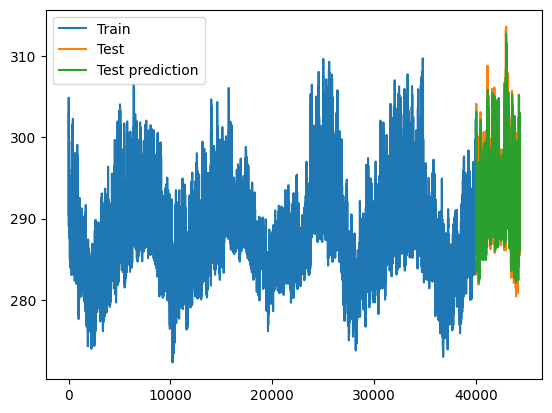

In [42]:
plt.plot(np.arange(len(X_train)), y_train, label='Train')
plt.plot(np.arange(len(X_train), len(X_train)+len(X_test), 1), y_test, label='Test')
plt.plot(np.arange(len(X_train), len(X_train)+len(X_test), 1), model.predict(X_test), label='Test prediction')
plt.legend()
plt.show()